In [1]:
import pandas as pd
from google.colab import drive

In [2]:
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Новый раздел

In [3]:
%cd /content/drive/My Drive/Colab Notebooks/Aslan

/content/drive/My Drive/Colab Notebooks/Aslan


In [109]:
df = pd.read_csv("rotten_tomatoes_movie_reviews.csv")

In [5]:
def convert_letter_grade(letter_grade):
    # Define mapping for alphabetic grades
    grades_mapping = {
        'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1,
        'A+': 5, 'A-': 5,
        'B+': 4, 'B-': 4,
        'C+': 3, 'C-': 3,
        'D+': 2, 'D-': 2,
    }
    return grades_mapping.get(letter_grade.upper(), None)

In [6]:
def convert_to_numeric(score):
    if isinstance(score, str):
        try:
            if "/" in score:
                # Numeric scores like "5/10", "3.5/5", etc.
                parts = score.split("/")
                if len(parts) == 2 and parts[0].replace('.', '', 1).isdigit() and parts[1].replace('.', '', 1).isdigit() and parts[1].replace('.', '', 1) == 5:
                    return int(float(parts[0]))
            else:
                    return convert_letter_grade(score)
        except Exception as e:
            print(e)
    return None

In [7]:
def process_input_text(text):
    if isinstance(text, str):
        return text
    else:
        return None

In [8]:
def convert_to_number(score):
    return int(score)

In [110]:
df['originalScore'] = df['originalScore'].apply(convert_to_numeric)

In [111]:
df['reviewText'] = df['reviewText'].apply(process_input_text)

In [113]:
df = df.dropna(subset=['originalScore', 'reviewText'])
df['originalScore'] = df['originalScore'].apply(convert_to_number)

In [114]:
df = df[[  'reviewText', 'originalScore']]


In [115]:
df = df.sample(n=70000, random_state=40)
len(df)

70000

In [116]:
unique_labels_counts = df['originalScore'].value_counts()
print(unique_labels_counts)

originalScore
4    33552
3    18900
5    11240
2     5446
1      862
Name: count, dtype: int64


In [14]:
df.head()

,reviewText,originalScore
1293489,Those open to this kind of hybridization will ...,4
1389652,"Filled with worthy, sometimes chilling, lesson...",4
21218,"One of the most original, narratively audaciou...",5
226937,In the absence of any larger drama of characte...,3
88045,"Action scenes shouldn't be dull, especially la...",3


In [15]:
import glob
import numpy as np
import os
import pandas as pd
import sys
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
print(len(df['originalScore'].unique()))

5


In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(df['originalScore'].unique()), # number of unique labels for our multi-class classification problem
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
class ReviewsDataset(Dataset):
    def __init__(self, df, max_length=512):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # input=review, label=stars
        review = self.df.loc[idx, 'reviewText']
        # labels are 0-indexed
        label = int(self.df.loc[idx, 'originalScore']) - 1

        encoded = self.tokenizer(
            review,                      # review to encode
            add_special_tokens=True,
            max_length=self.max_length,  # Truncate all segments to max_length
            padding='max_length',        # pad all reviews with the [PAD] token to the max_length
            return_attention_mask=True,  # Construct attention masks.
            truncation=True
        )

        input_ids = encoded['input_ids']
        attn_mask = encoded['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids),
            'attn_mask': torch.tensor(attn_mask),
            'label': torch.tensor(label)
        }

In [20]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=1)

In [21]:
test_dataset[:100].to_csv('/content/gold.csv')

In [31]:
MAX_LEN = 256
TEST_SIZE = 0.2
VAL_SIZE = 0.125
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

CHECKPOINT_FILE = 'checkpoint.dat'
CHECKPOINT_FOLDER = 'Checkpoint'
EPOCHS = 7
LEARNING_RATE = 2e-05
PROJECT_FOLDER = '/content/drive/My Drive/Colab Notebooks/Aslan/'
MODEL_FOLDER = 'Model_V3'
SAVE_EVERY = 100
NUM_WORKERS = 4

In [23]:
train_dataset, test_dataset = train_test_split(df, test_size=TEST_SIZE, random_state=1)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=VAL_SIZE, random_state=1)

train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = ReviewsDataset(train_dataset, MAX_LEN)
val_set = ReviewsDataset(val_dataset, MAX_LEN)
test_set = ReviewsDataset(test_dataset, MAX_LEN)

print("# of samples in train set: {}".format(len(train_set)))
print("# of samples in val set: {}".format(len(val_set)))
print("# of samples in test set: {}".format(len(test_set)))

# of samples in train set: 49000
# of samples in val set: 7000
# of samples in test set: 14000


In [24]:
train_params = {
                'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': NUM_WORKERS
                }
val_params = train_params

test_params = {
                'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': NUM_WORKERS
              }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
# For weighted Cross Entropy Loss
# Penalize errors higher if they come from a class with lower frequency
star_groups = df.groupby('originalScore')
star_distribution = []
for i in range(len(df['originalScore'].unique())):
    star_distribution.append(len(star_groups.groups[i+1])/len(df))

star_distribution = torch.tensor(star_distribution, dtype=torch.float32)

# V3
weights = 1.0 / star_distribution
weights = weights / weights.sum()

# V4
# weights = 1.0 - star_distribution

print('{:<20}: {}'.format('Star distribution', star_distribution.tolist()))
print('{:<20}: {}'.format('Weights', weights.tolist()))

Star distribution   : [0.012314286082983017, 0.07779999822378159, 0.27000001072883606, 0.47931429743766785, 0.16057142615318298]
Weights             : [0.7655375599861145, 0.1211702898144722, 0.03491499274969101, 0.01966778002679348, 0.05870937556028366]


In [26]:
# Define the optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=weights.to(device), reduction='mean')
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [27]:
# Define the accuracy function
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [28]:
# For validation
def validate(model, data_loader):
    model.eval()
    n_correct = 0
    nb_test_steps = 0
    nb_test_examples = 0
    test_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            input_ids = data['input_ids'].to(device)
            mask = data['attn_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids, mask)
            loss = loss_function(outputs[0], labels)
            test_loss += loss.item()

            # gets labels with highest probabilities and their corresponding indices
            big_val, big_idx = torch.max(outputs[0].data, dim=1)
            n_correct += calculate_accuracy(big_idx, labels)

            preds = (big_idx + 1).cpu().tolist()
            gold = (labels + 1).cpu().tolist()
            y_pred.extend(preds)
            y_true.extend(gold)

            nb_test_steps += 1
            nb_test_examples += labels.size(0)

    epoch_loss = test_loss/nb_test_steps
    epoch_accu = (n_correct*100)/nb_test_examples
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {epoch_accu}\n")

    return y_true, y_pred, epoch_accu

In [29]:
# Training loop
def train(epoch):
    # number of batches run by model
    nb_tr_steps = 0
    # number of training examples run by model
    nb_tr_examples = 0
    # number of examples classified correctly by model
    n_correct = 0
    tr_loss = 0
    model.train()

    for batch, data in enumerate(train_loader):
        input_ids = data['input_ids'].to(device)
        mask = data['attn_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(input_ids, mask)
        loss = loss_function(outputs[0], labels)
        tr_loss += loss.item()

        # gets labels with highest probabilities and their corresponding indices
        big_val, big_idx = torch.max(outputs[0].data, dim=1)
        n_correct += calculate_accuracy(big_idx, labels)

        nb_tr_steps += 1
        nb_tr_examples+=labels.size(0)

        if batch % SAVE_EVERY == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print("Batch {} of epoch {} complete.".format(batch, epoch+1))
            print(f"Training Loss: {loss_step}   Training Accuracy: {accu_step}")

            if not os.path.exists(CHECKPOINT_FOLDER):
              os.makedirs(CHECKPOINT_FOLDER)

            # Since a single epoch could take well over hours, we regularly save the model even during evaluation of training accuracy.
            torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
            print("Saving checkpoint at", os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print('\n*****\n')
    print(f'The Total Accuracy for Epoch {epoch+1}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss: {epoch_loss}")
    print(f"Training Accuracy: {epoch_accu}\n")

    # Evaluate model after training it on this epoch
    validate(model, val_loader)

    torch.save(model.state_dict(), os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
    model.save_pretrained(os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(epoch+1)))
    print("Saving checkpoint at ", os.path.join(PROJECT_FOLDER, CHECKPOINT_FOLDER, CHECKPOINT_FILE))
    print("Saving model at ", os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(epoch+1)), '\n\n================================================\n')

    return

In [32]:
# Training with weighted loss
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 0 of epoch 1 complete.
Training Loss: 1.587836503982544   Training Accuracy: 21.875
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 100 of epoch 1 complete.
Training Loss: 1.556159247266184   Training Accuracy: 28.372524752475247
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 200 of epoch 1 complete.
Training Loss: 1.442606210115537   Training Accuracy: 35.46330845771144
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 300 of epoch 1 complete.
Training Loss: 1.371899232713883   Training Accuracy: 39.79443521594684
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 400 of epoch 1 complete.
Training Loss: 1.3304951037849273   Training Accuracy: 41.583541147132166
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 500 of epoch 1 complete.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



*****

The Total Accuracy for Epoch 1: 48.155102040816324
Training Loss: 1.1921303519692183
Training Accuracy: 48.155102040816324

Validation Loss: 1.0537285303960653
Validation Accuracy: 49.142857142857146

Saving checkpoint at  /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Saving model at  /content/drive/My Drive/Colab Notebooks/Aslan/Model_V3/1 


Batch 0 of epoch 2 complete.
Training Loss: 0.8458103537559509   Training Accuracy: 53.125
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 100 of epoch 2 complete.
Training Loss: 0.9143324441248828   Training Accuracy: 57.70420792079208
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 200 of epoch 2 complete.
Training Loss: 0.917007170061567   Training Accuracy: 58.02238805970149
Saving checkpoint at /content/drive/My Drive/Colab Notebooks/Aslan/Checkpoint/checkpoint.dat
Batch 300 of epoch 2 complete.
Training Los

In [33]:
# Evaluation on test set
for epoch in range(1, EPOCHS+1):
  model = BertForSequenceClassification.from_pretrained(os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(epoch))).cuda()
  print(f'Running validation on model trained on {epoch} epochs')

  validate(model, test_loader)

Running validation on model trained on 1 epochs
Validation Loss: 1.057652183999754
Validation Accuracy: 49.16428571428571

Running validation on model trained on 2 epochs
Validation Loss: 1.1208649119830023
Validation Accuracy: 60.27857142857143

Running validation on model trained on 3 epochs
Validation Loss: 1.251235906664095
Validation Accuracy: 54.878571428571426

Running validation on model trained on 4 epochs
Validation Loss: 1.4562898000625715
Validation Accuracy: 55.628571428571426

Running validation on model trained on 5 epochs
Validation Loss: 1.6445264997275453
Validation Accuracy: 59.5

Running validation on model trained on 6 epochs
Validation Loss: 1.9836952887713637
Validation Accuracy: 59.30714285714286

Running validation on model trained on 7 epochs
Validation Loss: 2.178463721656364
Validation Accuracy: 59.69285714285714



In [34]:
def get_single_prediction(review, model):
  """
  Predict a star rating from a review comment.

  :comment: the string containing the review comment.
  :model: the model to be used for the prediction.
  """

  df = pd.DataFrame()
  df['reviewText'] = [review]
  df['originalScore'] = ['0']

  dataset = ReviewsDataset(df)

  TEST_BATCH_SIZE = 1
  NUM_WORKERS = 1

  test_params = {'batch_size': TEST_BATCH_SIZE,
              'shuffle': True,
              'num_workers': NUM_WORKERS}

  data_loader = DataLoader(dataset, **test_params)

  total_examples = len(df)
  predictions = np.zeros([total_examples], dtype=object)

  for batch, data in enumerate(data_loader):

    # Get the tokenization values.
    input_ids = data['input_ids'].to(device)
    mask = data['attn_mask'].to(device)

    # Make the prediction with the trained model.
    outputs = model(input_ids, mask)

    # Get the star rating.
    big_val, big_idx = torch.max(outputs[0].data, dim=1)
    star_predictions = (big_idx + 1).cpu().numpy()

  return star_predictions[0]


In [35]:
review = "Bella’s appetite for novelty is reflected in film-making that evokes a similar sense of wonder and discovery in the audience."

In [36]:
prediction = get_single_prediction(review, model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [37]:
print((prediction))

4


In [38]:
!pip install Unidecode
!pip install word2number

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5566 sha256=ca3ccf92010914e68cb818458aefecad2a73692bf53bfe7a998012e842fcd0c6
  Stored in directory: /root/.cache/pip/wheels/84/ff/26/d3cfbd971e96c5aa3737ecfced81628830d7359b55fbb8ca3b
Successfully built word2number


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [40]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import string
import unidecode
import re
import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [71]:
new_df = pd.read_csv("rotten_tomatoes_movie_reviews.csv")

In [72]:
new_df['originalScore'] = new_df['originalScore'].apply(convert_to_numeric)

In [73]:
new_df['reviewText'] = new_df['reviewText'].apply(process_input_text)

In [74]:
new_df = new_df.dropna(subset=['originalScore', 'reviewText'])
new_df['originalScore'] = new_df['originalScore'].apply(convert_to_number)

In [75]:
new_df = new_df[[  'reviewText', 'originalScore']]

In [76]:
new_df.head()

,reviewText,originalScore
12,"Ridiculous, artless, and wildly entertaining, ...",4
13,To sit through it feels like honoring the drea...,3
22,Naczek isn&apos;t interested in making a soap ...,4
24,Debuting screenwriter Jason Naczek has concoct...,3
25,Small Town Wisconsin is always proving itself ...,4


In [77]:
print(len(new_df))

152956


In [48]:
tokenizer = RegexpTokenizer(r"\w+[a-zA-Z]")

In [49]:
def remove_nums(text):
  text = re.sub("\d+", " ", text)
  return text

# Remove stop words
def remove_stopwords(text):
  stoplist = stopwords.words('english')
  not_stopwords = {'no', 'not'} # should not remove these if doing sentiment analysis
  stoplist = set([word for word in stoplist if word not in not_stopwords])
  words = [w for w in text if w not in stoplist]
  return words

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  lem_text = [lemmatizer.lemmatize(i) for i in text]
  return lem_text

# Convert accented characters to ascii
def remove_accents(text):
  text = unidecode.unidecode(text)
  return text

def join_words(text):
  return ' '.join([word for word in text]).strip()


In [50]:
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: remove_accents(x))
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: remove_nums(x))
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: tokenizer.tokenize(x.lower())) # tokenizes and convert to lowercase
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: remove_stopwords(x))
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: lemmatize(x))
new_df['reviewText'] = new_df['reviewText'].apply(lambda x: join_words(x))

In [51]:
new_df.head()

,reviewText,originalScore
12,ridiculous artless wildly entertaining dangero...,4
13,sit feel like honoring dreamer world least get...,3
22,naczek apos interested making soap opera exami...,4
24,debuting screenwriter jason naczek concocted m...,3
25,small town wisconsin always proving familiar p...,4


In [52]:

TEST_SIZE = 0.2

In [53]:
train_dataset, test_dataset = train_test_split(new_df, test_size=TEST_SIZE, random_state=1)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

print("# of samples in train set: {}".format(len(train_dataset)))
print("# of samples in test set: {}".format(len(test_dataset)))

# of samples in train set: 122364
# of samples in test set: 30592


In [54]:
y_train = train_dataset['originalScore']
y_test = test_dataset['originalScore']

In [55]:
y_pred = np.full(shape=y_test.shape, fill_value=5, dtype=int)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       384
           2     0.0000    0.0000    0.0000      2306
           3     0.0000    0.0000    0.0000      8228
           4     0.0000    0.0000    0.0000     14799
           5     0.1594    1.0000    0.2749      4875

    accuracy                         0.1594     30592
   macro avg     0.0319    0.2000    0.0550     30592
weighted avg     0.0254    0.1594    0.0438     30592



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:

# For Multinomial Naive Bayes
tfidf_vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features=5000
)

# Bag-of-words representation for Logistic Regression and Multinomial Naive Bayes
count_vectorizer = CountVectorizer(
    stop_words='english',
    max_features=5000
)

In [57]:

def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
  cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
  np.set_printoptions(precision=2)

  plt.figure()
  plot(cnf_matrix, classes=[1,2,3,4,5],
        title=title)

def plot(cm, classes,
        normalize=False,
        title='Confusion Matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    print('\n', sep='')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix
[[    0     0     0     0   384]
 [    0     0     0     0  2306]
 [    0     0     0     0  8228]
 [    0     0     0     0 14799]
 [    0     0     0     0  4875]]




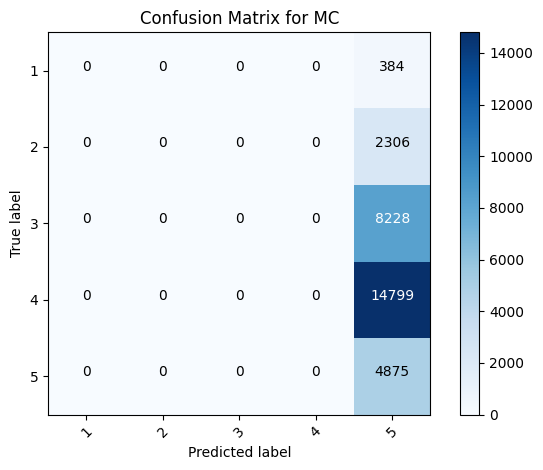

In [58]:

plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MC')

In [59]:
X_train = count_vectorizer.fit_transform(train_dataset['reviewText'])
X_test = count_vectorizer.fit_transform(test_dataset['reviewText'])

In [60]:
mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

In [61]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.0175    0.0677    0.0278       384
           2     0.1138    0.1127    0.1133      2306
           3     0.3198    0.2059    0.2505      8228
           4     0.4973    0.6249    0.5538     14799
           5     0.2224    0.1335    0.1669      4875

    accuracy                         0.3883     30592
   macro avg     0.2342    0.2290    0.2225     30592
weighted avg     0.3708    0.3883    0.3708     30592



Confusion matrix
[[  26   43   72  211   32]
 [ 123  260  459 1270  194]
 [ 414  692 1694 4783  645]
 [ 673  991 2482 9248 1405]
 [ 250  299  590 3085  651]]




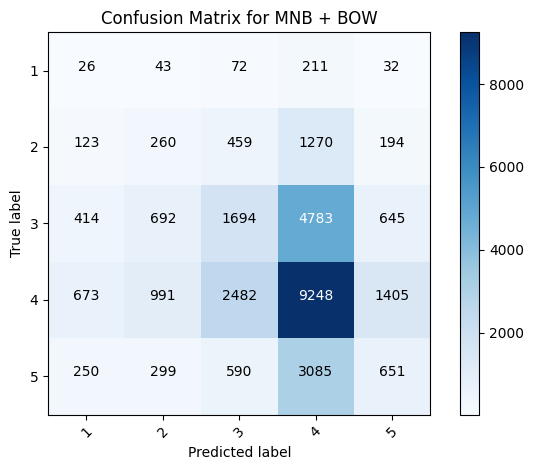

In [62]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MNB + BOW')

In [63]:
X_train = tfidf_vectorizer.fit_transform(train_dataset['reviewText'])
X_test = tfidf_vectorizer.fit_transform(test_dataset['reviewText'])


In [64]:

mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

In [65]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       384
           2     0.1014    0.0030    0.0059      2306
           3     0.3408    0.1519    0.2102      8228
           4     0.4927    0.8905    0.6344     14799
           5     0.2642    0.0057    0.0112      4875

    accuracy                         0.4728     30592
   macro avg     0.2398    0.2102    0.1723     30592
weighted avg     0.3797    0.4728    0.3656     30592



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix
[[    0     2    64   317     1]
 [    0     7   409  1883     7]
 [    0    20  1250  6933    25]
 [    0    33  1543 13178    45]
 [    0     7   402  4438    28]]




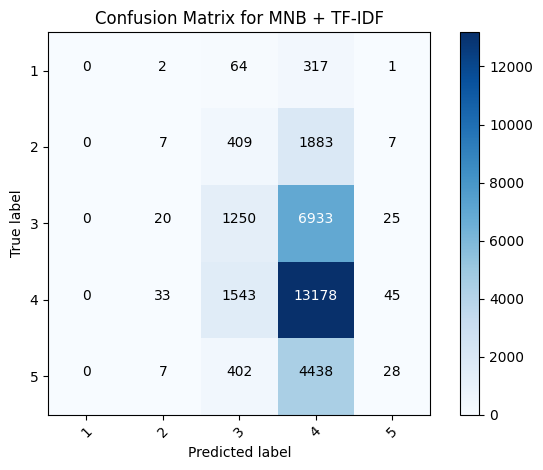

In [66]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for MNB + TF-IDF')


In [67]:

X_train = count_vectorizer.fit_transform(train_dataset['reviewText'])
X_test = count_vectorizer.fit_transform(test_dataset['reviewText'])

In [68]:
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)

In [69]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.0455    0.0078    0.0133       384
           2     0.1056    0.0854    0.0945      2306
           3     0.3271    0.2470    0.2814      8228
           4     0.4978    0.6871    0.5773     14799
           5     0.2163    0.0896    0.1268      4875

    accuracy                         0.4197     30592
   macro avg     0.2385    0.2234    0.2187     30592
weighted avg     0.3718    0.4197    0.3825     30592



Confusion matrix
[[    3    34    86   239    22]
 [    4   197   554  1421   130]
 [   16   588  2032  5157   435]
 [   27   807  2800 10169   996]
 [   16   239   740  3443   437]]




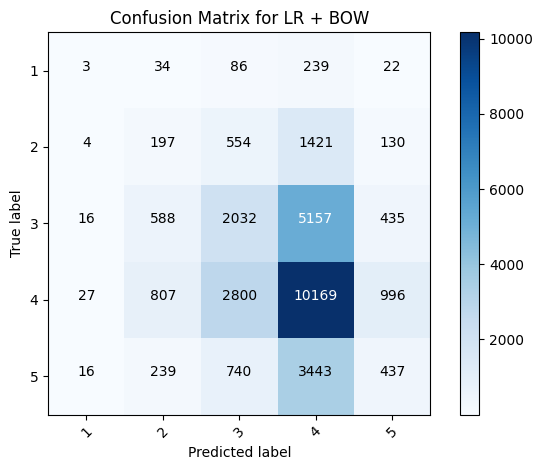

In [70]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for LR + BOW')

In [78]:

def calculate_accuracy(predictions, targets):
  """
  Calculate the accuracy of the predictions.

  :predictions: the predicted star ratings.
  :targets: the ground-truth labels.
  """

  num_correct = (predictions == targets).sum().item()

  return num_correct

In [79]:
print(device)

cuda


In [99]:
def get_star_predictions(df, model):
  """
  Uses the given pretrained model to predict star ratings based on
  reviews. Returns an array with the original reviews and their star
  predictions, as well as the accuracy of the predictions.

  :df: DataFrame containing reviews and their labels.
  :model: loaded pretrained BERT model.
  """

  # Define the prediction parameters.
  MAX_LEN = 256
  TEST_BATCH_SIZE = 16
  NUM_WORKERS = 4

  test_params = {'batch_size': TEST_BATCH_SIZE,
              'shuffle': False,
              'num_workers': NUM_WORKERS}

  # Define the dataset and dataloader.
  dataset = ReviewsDataset(df, MAX_LEN)
  data_loader = DataLoader(dataset, **test_params)
  num_batches = 0
  num_examples = 0
  num_correct = 0
  total_examples = len(df)
  predictions = np.zeros([total_examples, 2], dtype=object)
  for batch, data in enumerate(data_loader):
    # Get the tokenization values.
    input_ids = data['input_ids'].to(device)
    mask = data['attn_mask'].to(device)
    labels = data['label'].to(device)
    # Make predictions with the trained model
    outputs = model(input_ids, mask)
    # Get the star ratings.
    big_val, big_idx = torch.max(outputs[0].data, dim=1)
    star_predictions = (big_idx + 1).cpu().numpy()
    reviews = df['reviewText'].values[num_examples:num_examples + labels.size(0)]
    batch = np.vstack((reviews, star_predictions)).T

    # Update the output.
    predictions[num_examples:num_examples + labels.size(0)] = batch

    num_correct += calculate_accuracy(big_idx, labels)

    num_batches += 1
    num_examples += labels.size(0)

    if num_batches % 10 == 0:
      print("Batch #{}: {}/{}".format(num_batches, num_examples, total_examples))

  accuracy = (num_correct * 100) / num_examples

  print("Finished predictions! Accuracy:", accuracy)

  return predictions, accuracy

In [81]:
import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [96]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(new_df['originalScore'].unique()),
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [97]:
model = BertForSequenceClassification.from_pretrained(os.path.join(PROJECT_FOLDER, MODEL_FOLDER, str(6)))
model.to(device)
print(device)
model.eval()

cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# predict_list = []
# counter = 1
# for x in df['reviewText']:

#   predict_list.append(int(get_single_prediction(x, model)) )
#   print(counter, predict_list[-1])
#   counter+=1

# new_df['predictScore'] = predict_list
# new_df.head()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


2 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


3 4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

In [90]:
df = pd.read_csv("rotten_tomatoes_movie_reviews.csv")
df['originalScore'] = df['originalScore'].apply(convert_to_numeric)
df['reviewText'] = df['reviewText'].apply(process_input_text)
df = df.dropna(subset=['originalScore', 'reviewText'])
df['originalScore'] = df['originalScore'].apply(convert_to_number)
df = new_df[[  'reviewText', 'originalScore']]
df.head()

,reviewText,originalScore
12,"Ridiculous, artless, and wildly entertaining, ...",4
13,To sit through it feels like honoring the drea...,3
22,Naczek isn&apos;t interested in making a soap ...,4
24,Debuting screenwriter Jason Naczek has concoct...,3
25,Small Town Wisconsin is always proving itself ...,4


In [92]:
df = df.reset_index(drop=True)
print(len(df))

152956


In [100]:
predictions, accuracy = get_star_predictions(df, model)


Batch #10: 160/152956
Batch #20: 320/152956
Batch #30: 480/152956
Batch #40: 640/152956
Batch #50: 800/152956
Batch #60: 960/152956
Batch #70: 1120/152956
Batch #80: 1280/152956
Batch #90: 1440/152956
Batch #100: 1600/152956
Batch #110: 1760/152956
Batch #120: 1920/152956
Batch #130: 2080/152956
Batch #140: 2240/152956
Batch #150: 2400/152956
Batch #160: 2560/152956
Batch #170: 2720/152956
Batch #180: 2880/152956
Batch #190: 3040/152956
Batch #200: 3200/152956
Batch #210: 3360/152956
Batch #220: 3520/152956
Batch #230: 3680/152956
Batch #240: 3840/152956
Batch #250: 4000/152956
Batch #260: 4160/152956
Batch #270: 4320/152956
Batch #280: 4480/152956
Batch #290: 4640/152956
Batch #300: 4800/152956
Batch #310: 4960/152956
Batch #320: 5120/152956
Batch #330: 5280/152956
Batch #340: 5440/152956
Batch #350: 5600/152956
Batch #360: 5760/152956
Batch #370: 5920/152956
Batch #380: 6080/152956
Batch #390: 6240/152956
Batch #400: 6400/152956
Batch #410: 6560/152956
Batch #420: 6720/152956
Batch #

In [103]:
print(type(predictions.tolist()))
print(predictions.tolist()[0])

<class 'list'>
['Ridiculous, artless, and wildly entertaining, Dangerous Men is more than the sum of its fascinatingly misguided parts, although it will take a special sort of moviegoer to truly appreciate (or endure, depending on your perspective) its charms.', 4]


In [104]:
y_pred = list()
for text, score in predictions:
  y_pred.append(int(score))
print(len(y_pred))

152956


In [106]:
y_test = df['originalScore'].tolist()

In [107]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.6565    0.4217    0.5136      1840
           2     0.5328    0.6099    0.5687     11707
           3     0.6634    0.7448    0.7017     41411
           4     0.8065    0.6746    0.7347     73360
           5     0.5749    0.7121    0.6362     24638

    accuracy                         0.6917    152956
   macro avg     0.6468    0.6326    0.6310    152956
weighted avg     0.7077    0.6917    0.6945    152956



Confusion matrix
[[  776   631   319    85    29]
 [  277  7140  3574   604   112]
 [   94  4703 30841  5198   575]
 [   27   784 10803 49491 12255]
 [    8   144   953  5988 17545]]




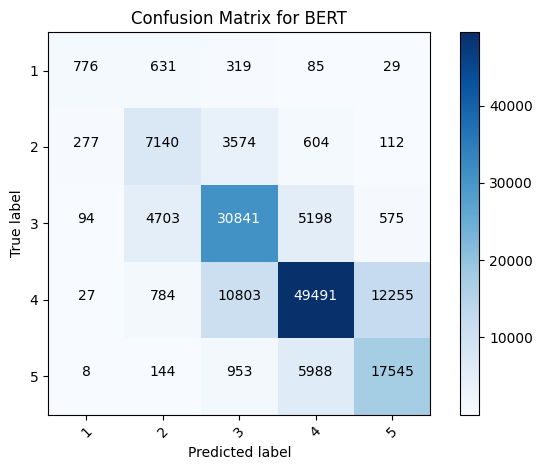

In [117]:
plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix for BERT')